# Neural Language Modeling

In [37]:
import pandas as pd

In [38]:
df = pd.read_csv('data/ratings_train.txt', sep='\t')

In [39]:
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [40]:
df.shape

(150000, 3)

In [41]:
df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [42]:
df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [43]:
df.loc[df['document'].isna(), :]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [44]:
df = df.dropna(how='any', axis=0)

In [45]:
df.shape

(149995, 3)

---
## Tokenization

In [46]:
vocab_cnt_dict = {} 
for doc in df['document']:
    for token in list(doc):
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [47]:
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [48]:
vocab_cnt_list[:10]

[('아', 47071),
 (' ', 987741),
 ('더', 9863),
 ('빙', 738),
 ('.', 241461),
 ('진', 18522),
 ('짜', 11514),
 ('증', 2160),
 ('나', 42976),
 ('네', 18756)]

In [49]:
len(vocab_cnt_list)

3004

In [50]:
top_vocabs = sorted(vocab_cnt_list, key=lambda tup:tup[1], reverse=True)

In [51]:
import matplotlib.pyplot as plt
import numpy as np

In [52]:
cnts = [cnt for _, cnt in top_vocabs]

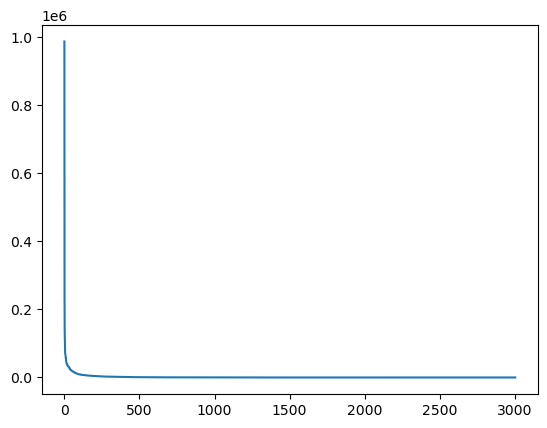

In [53]:
plt.plot(range(len(cnts)), cnts)

In [54]:
np.mean(cnts)

1757.8239014647138

In [55]:
vocabs = [token for token, _ in vocab_cnt_list]

In [56]:
len(vocabs)

3004

---
## Add Special Tokens

In [57]:
# pad, unk, sos, eos
special_tokens = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']
for special_token in special_tokens[::-1]:
    vocabs.insert(0, special_token)

In [58]:
idx_to_token = vocabs
token_to_idx = {token: i for i, token in enumerate(idx_to_token)}

In [59]:
class Tokenizer:
    def __init__(self,
                 vocabs,
                 use_padding=True,
                 max_padding=64,
                 pad_token='[PAD]',
                 unk_token='[UNK]',
                 sos_token='[SOS]',
                 eos_token='[EOS]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        
        self.use_padding = use_padding
        self.max_padding = max_padding
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]
        self.sos_token_idx = self.token_to_idx[self.sos_token]
        self.eos_token_idx = self.token_to_idx[self.eos_token]
        
        
    def __call__(self, x):
        token_ids = [self.sos_token_idx]
        
        token_list = list(x)
        
        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)
            
        token_ids.append(self.eos_token_idx)
            
        if self.use_padding:
            token_ids.pop()
            token_ids = token_ids[:self.max_padding-1]
            n_pads = self.max_padding - len(token_ids) - 1
            token_ids = token_ids + [self.eos_token_idx] +[self.pad_token_idx] * n_pads
        
        return token_ids
    
    def cvt_ids_to_tokens(self, ids):
        return [self.idx_to_token[idx] for idx in ids]
    
    def cvt_ids_to_str(self, ids):
        return ''.join([self.idx_to_token[idx] for idx in ids])

In [60]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [61]:
sample = df['document'].iloc[0]
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [62]:
tokenizer(sample)

[2, 4, 5, 6, 7, 8, 8, 5, 9, 10, 5, 10, 11, 12, 13, 14, 5, 15, 16, 17, 3]

---
## DataLoader

In [63]:
import torch
from torch.utils.data import Dataset, DataLoader

In [64]:
train_valid_df = pd.read_csv('data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('data/ratings_test.txt', sep='\t')

In [65]:
train_valid_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [66]:
train_ratio = 0.8

n_train = int(len(train_valid_df) * train_ratio)

train_df = train_valid_df[:n_train]
valid_df = train_valid_df[n_train:]

In [67]:
train_df = train_df.sample(frac=0.01)
valid_df = valid_df.sample(frac=0.01)
test_df = test_df.sample(frac=0.01)

In [68]:
class NSMCDataset(Dataset):
    
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer
        
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        
        sample['doc'] = str(sample_raw['document'])
        
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc']) 
        
        return sample

In [69]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}

    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [70]:
train_dataset = NSMCDataset(data_df=train_df, tokenizer=tokenizer)
valid_dataset = NSMCDataset(data_df=valid_df, tokenizer=tokenizer)
test_dataset = NSMCDataset(data_df=test_df, tokenizer=tokenizer)

train_dataloader= DataLoader(train_dataset,
                             batch_size=128,
                             collate_fn=collate_fn,
                             shuffle=True)

valid_dataloader= DataLoader(valid_dataset,
                             batch_size=1024,
                             collate_fn=collate_fn,
                             shuffle=False)

test_dataloader= DataLoader(test_dataset,
                            batch_size=1024,
                            collate_fn=collate_fn,
                            shuffle=False)

In [71]:
sample = next(iter(test_dataloader))
# sample